In [5]:
import numpy as np
import matplotlib.pyplot as plt
import colorednoise as cn

from os import makedirs
from os.path import exists, join
from scipy.signal import welch

from lagged_autocoherence import generate_surrogate, lagged_hilbert_autocoherence
from utils import scale_noise

In [8]:
surr_method_labels = ["AR(1)", "phase-shuffled"]

f=np.load('../output/sims/surrogate/sim_results.npz')
osc_f=f['osc_f']
surr_methods=f['surr_methods']
freqs=f['freqs']
lags=f['lags']
f_psds=f['f_psds']
f_surrogate_psds=f['f_surrogate_psds']
f_surrogate_lhc=f['f_surrogate_lhc']

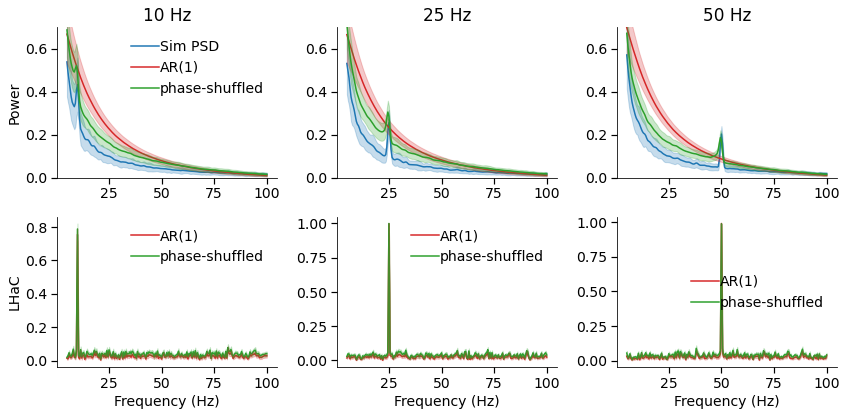

In [10]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

psd_color = "tab:blue"
surr_colors = ["tab:red","tab:green"]

fig = plt.figure(
    figsize=(12, 6)
)
gs = fig.add_gridspec(
    nrows=2,
    ncols=3
)


for f, fr in enumerate(osc_f):
    psds = f_psds[f,:,:]
    psd = ( psds - np.nanmin(psds) ) / ( np.nanmax(psds) - np.nanmin(psds) ) # np.nanmax(psds) #
    psd_m = np.nanmean(psd, axis=0)
    psd_sd = np.nanstd(psd, axis=0)

    # Plot.
    ax = fig.add_subplot(gs[0,f])

    ax.plot(
        freqs,
        psd_m,
        label='Sim PSD',
        color=psd_color,
        zorder=0,
    )
    ax.fill_between(
        freqs,
        psd_m - psd_sd,
        psd_m + psd_sd,
        color=psd_color,
        alpha=0.25,
        zorder=0,
    )
    
    for m, method in enumerate(surr_method_labels):
        surrogate_psds=f_surrogate_psds[f,m,:,:,:]
        # Average data across shuffles and apply scaling.
        sap = np.nanmean(surrogate_psds, axis=1)
        sap = ( sap - np.nanmin(sap) ) / ( np.nanmax(sap) - np.nanmin(sap) ) # np.nanmax(sap) #
        sap_m = np.nanmean(sap, axis=0)
        sap_sd = np.nanstd(sap, axis=0)

        ax.plot(
            freqs,
            sap_m,
            label=method,
            color=surr_colors[m],
            zorder=m+1,
        )
        ax.fill_between(
            freqs,
            sap_m - sap_sd,
            sap_m + sap_sd,
            color=surr_colors[m],
            alpha=0.25,
            zorder=m+1,
        )

    ax.set_title("{} Hz".format(fr))
    ax.set_ylim([0, 0.7])

    if f == 0:
        ax.legend(loc="upper right")
        ax.set_ylabel('Power')
      
    ax = fig.add_subplot(gs[1,f])
            
    for m, method in enumerate(surr_method_labels):
        l_idx=np.where((lags>=2) & (lags<=3))[0]
        lch = f_surrogate_lhc[f,m,:,:,:]
        lch = np.mean(lch[:,:,l_idx],axis=-1)
        lch = ( lch - np.nanmin(lch) ) / ( np.nanmax(lch) - np.nanmin(lch) ) # np.nanmax(lch) #
        lch_m = np.nanmean(lch, axis=0)
        lch_sd = np.nanstd(lch, axis=0)/np.sqrt(lch.shape[0])

        # Plot.        
        ax.plot(
            freqs,
            lch_m,
            label=method,
            color=surr_colors[m],
            zorder=0,
        )
        ax.fill_between(
            freqs,
            lch_m - lch_sd,
            lch_m + lch_sd,
            color=surr_colors[m],
            alpha=0.25,
            zorder=1,
        )
    ax.set_xlabel('Frequency (Hz)')
        
    if f == 0:
        ax.legend()
        ax.set_ylabel('LHaC')
    
plt.tight_layout()
fig.savefig('../output/figures/surrogate_comparison.pdf')